In [44]:
import networkx as nx
import json

import umap.umap_ as umap
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

from karateclub.utils.walker import RandomWalker, BiasedRandomWalker
from gensim.models.word2vec import Word2Vec
%matplotlib inline

I used facebook page-page networks to implement node2vec. This dataset can be downloaded at this [link](https://snap.stanford.edu/data/facebook-large-page-page-network.html)
There are 3 files - edges, targets, and features.

In [3]:
# Read facebook edges file using pandas read method
edges_path = edges = pd.read_csv(r'C:\Users\srava\OneDrive\Desktop\Data Semantics\node2Vec\facebook_large\facebook_edges.csv')

# Display links or edges between the facebook page-page data
edges.head()

,id_1,id_2
0,0,18427
1,1,21708
2,1,22208
3,1,22171
4,1,6829


In [4]:
# Read page-page facebook nodes file using pandas read method
nodes = pd.read_csv(r'C:\Users\srava\OneDrive\Desktop\Data Semantics\node2Vec\facebook_large\facebook_target.csv')
nodes.index = nodes.id

# Display links or edges between the facebook page-page data
nodes.head()

,id,facebook_id,page_name,page_type
id,,,,
0,0,145647315578475,The Voice of China 中国好声音,tvshow
1,1,191483281412,U.S. Consulate General Mumbai,government
2,2,144761358898518,ESET,company
3,3,568700043198473,Consulate General of Switzerland in Montreal,government
4,4,1408935539376139,Mark Bailey MP - Labor for Miller,politician


Facebook's page-page data consists of node id, facebook id, name of the page and type of the page.

Let's see the total number of nodes and edges retrieved from the dataset

In [5]:
print("Total number of nodes :" , len(nodes.index))
print("Total number of edges :" , len(edges.index))

Total number of nodes : 22470
Total number of edges : 171002


In [8]:
# Reading the json as a dict
with open(r"C:\Users\srava\OneDrive\Desktop\Data Semantics\node2Vec\facebook_large\facebook_features.json") as json_data:
    features = json.load(json_data)

In [10]:
# Read the data from the features json
max_feature = np.max([v for v_list in features.values() for v in v_list])
features_matrix = np.zeros(shape = (len(list(features.keys())), max_feature+1))

i = 0
for k, vs in tqdm(features.items()):
    for v in vs:
        features_matrix[i, v] = 1
    i+=1

100%|████████████████████████████████████████████████████████████████████████| 22470/22470 [00:00<00:00, 103804.65it/s]


Now that we are reading the data, we can go ahead to create a graph.

Let's visualize the data by creating a graph from the dataset.

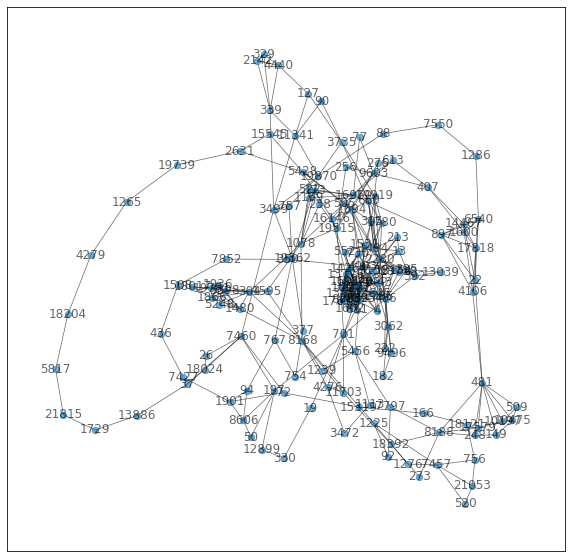

In [11]:
# create graph
G = graph= nx.from_pandas_edgelist(edges, "id_1", "id_2", create_using=nx.Graph())

# Visualise some subgraph of 150 nodes
subgraph_nodes = list(nx.dfs_preorder_nodes(graph, 4))[:150] #Gets all the nodes in the graph that node 4 belongs to.

# plot graph
plt.figure(figsize=(10,10))

SG = graph.subgraph(subgraph_nodes)
pos = nx.spring_layout(SG, seed=42)
nx.draw_networkx(SG, pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

The above graph is a subset of the graph G and the plot illustrates the nodes that belongs to 4. 
This looks huge only for a single node.

Now let's visualize the complete graph and see how does it look

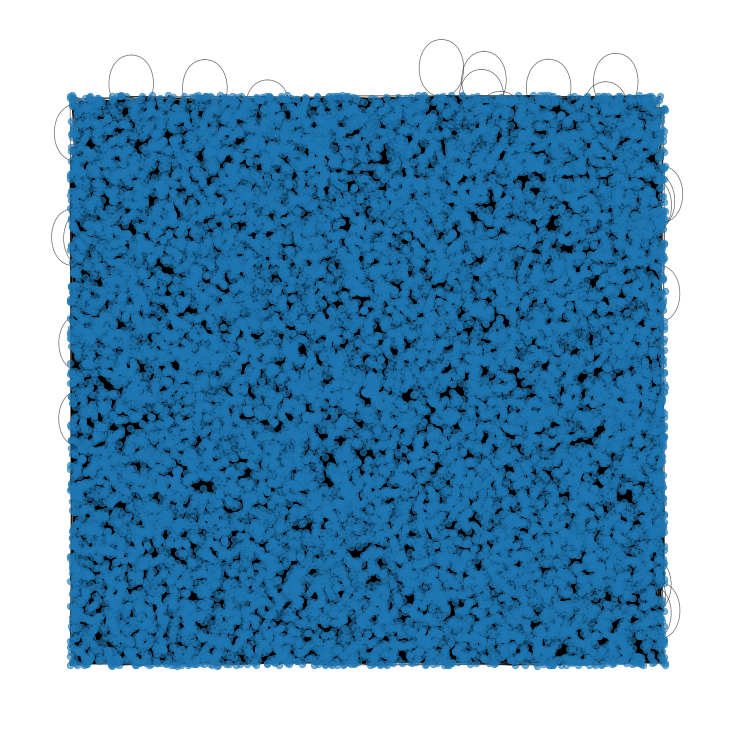

In [12]:
# plot graph
plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

We can barely see any link or edge between the nodes as we have astrnomical amount of nodes and we might get to work on such huge datasets.

### Random Walk

A random walk on a graph can be imagined as a walker traversing the graph along its edges. The walker must decide where to go next and then move to the next state at each step. This is known as 1-hop transition.

In second order, the 1-hop transitions also incorporates information of the previous state along with the current state.
node2vec applies a bias factor alpha(α), which is used to reweight the edge weights based on the previous state. So, this is called second order biased random walk.

If two nodes are not connected, then α = 1/q (q = in-out parameter)

If q is small, then it’s restricted to local neighborhood(homophily) and if q is large, structural equivalence is achieved.

If two nodes are identical, then α = 1/p (p = return parameter).

If two nodes are connected but not similar, then α = 1

In [13]:
def biased_walk(start_node, walk_length, p, q):
    walk = [start_node]
    previous_node = None
    previous_node_neighbors = []
    for _ in range(walk_length-1):
        current_node = walk[-1]  # currnet node ID
        current_node_neighbors = np.array(list(graph.neighbors(current_node)))  # negihbours of this node
        probability = np.array([1/q] * len(current_node_neighbors), dtype=float)  # outwards probability weight determined by q
        probability[current_node_neighbors==previous_node] = 1/p  # probability of return determined by p
        probability[(np.isin(current_node_neighbors, previous_node_neighbors))] = 1  # weight of 1 to all the neighbours which are connected to the previous node as well
        norm_probability = probability/sum(probability)  # normalize the probablity
        selected = np.random.choice(current_node_neighbors, 1, p=norm_probability)[0]  # select the node from neighbours according to the probabilities from above
        walk.append(selected)  # append to the walk and continue
        previous_node_neighbors = current_node_neighbors
        previous_node = current_node
    
    return walk

Lets see the difference how the walks are affected by the values of p and q.

Let's compare 2 extreme scenarios:
When p = 10, q = 0.1 - here we expect the random walk to go outwards and explore the adjacent clusters as well
When p = 0.1, q = 10 - here we expect the random walk to stay very local and explore the neighbourhood around the starting node

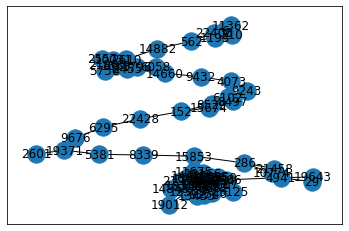

In [45]:
p = 1
q = 0.1
walk = biased_walk(6, 80, p, q)
# Visualise the subgraph
subgraph_nodes = list(nx.dfs_preorder_nodes(graph, 4))
G = graph.subgraph(walk)
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx(G, pos=pos)

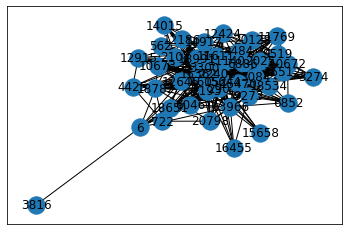

In [46]:
p = 1
q = 10
walk = biased_walk(6, 80, p, q)
# Visualise the subgraph
subgraph_nodes = list(nx.dfs_preorder_nodes(graph, 4)) 
G = graph.subgraph(walk)
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx(G, pos=pos, cmap='coolwarm')

From the images we can see the differences between the resulting random walks. Each problem will have its own perfect p and q parameters so we can treat them as hyperparameters to tune.Generate 

Now, we generate corpus using random biased walks as required by node2vec. The random walks have fixed maximum length and are controlled by two parameters p and q.
We are going to start 10 random walks from each node in the graph with a length up to 80. We set parameter


In [18]:
graph = nx.convert_matrix.from_pandas_edgelist(edges, "id_1", "id_2")
b_walker = BiasedRandomWalker(
    80 # maximum length of a random walk, 
    10 # number of random walks per root node,
    0.5 # Defines probability, 1/p, of returning to source node, 
    0.25 # Defines probability, 1/q, for moving away from source node)
b_walker.do_walks(graph)

In [33]:
# node2vec uses skip gram model from word2vec, so we use word2vec to get the vector representations of the graph

node_vec = Word2Vec(b_walker.walks,  # previously generated walks
                 hs=1,  # tells the model to use hierarchical softmax
                 sg = 1,  # tells the model to use skip-gram
                 vector_size=128,  # size of the embedding
                 window=10,
                 min_count=1,
                 epochs = 1,
                 workers=4,
                 seed=42)

In [36]:
similar_to = '4' # Find nodes which are similar to 4
nodes.loc[[int(similar_to)] + [int(v[0]) for v in node_vec.wv.most_similar(similar_to)], :].head()

,id,facebook_id,page_name,page_type
id,,,,
4,4,1408935539376139,Mark Bailey MP - Labor for Miller,politician
16203,16203,289973794486663,Craig Crawford - Labor For Barron River,politician
9706,9706,1389185004695396,Coralee O'Rourke MP,politician
9263,9263,612853245438547,Mick de Brenni for Springwood,politician
5356,5356,394508164021609,Peter Russo - Labor for Toohey,politician


In [37]:
similar_to = '451' # Find nodes which are similar to 451
nodes.loc[[int(similar_to)] + [int(v[0]) for v in node_vec.wv.most_similar(similar_to)], :].head()

,id,facebook_id,page_name,page_type
id,,,,
451,451,104667776288021,BBC Apprentice,tvshow
1429,1429,100865096953196,BBC Archive,tvshow
926,926,408902742628123,BBC Watchdog,tvshow
9997,9997,526813830804091,BBC Points of View,tvshow
14787,14787,127439507270196,BBC Breakfast,tvshow


As you can see, the nearest neighbours are incredibly similar to the original pages and all of this is achieved without even knowing what the original pages are about! Hence, the embeddings that the DeepWalk has learned are meaningful and we can use them in the classifier. We can build a simple Random Forest model to see what performance we can achieve using purely the embeddings.

##### Downstream task

The node embeddings calculated using Word2Vec can be used as feature vectors in a downstream task such as node attribute inference.

In this example, we will use the Node2Vec node embeddings to train a classifier to predict the future connections in the facebook pages.

In [38]:
# Get targets 
y = nodes.loc[[int(i) for i in list(features.keys())], 'page_type']

In [39]:
# Get corresponding Node2Vec embeddings
X_node_vec = []
for i in y.index:
    X_node_vec.append(node_vec.wv.__getitem__(str(i)))

###### Data Splitting
We split the data into train and test sets.

We use 75% of the data for training and the remaining 25% for testing as a hold out test set.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_node_vec, y, test_size=0.25) # train/test split

###### Classifier Training
We train a Random Forest classifier on the training data.

In [41]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


Predict the hold out test set.
The F1-score is a measure of a test's accuracy.

In [42]:
print(f1_score(y_test, y_pred, average='micro'))
print(confusion_matrix(y_test, y_pred, normalize='true'))

0.9343182627269491
[[0.94915254 0.03075957 0.00502197 0.01506591]
 [0.02318841 0.94434783 0.03246377 0.        ]
 [0.00816882 0.04220558 0.94826413 0.00136147]
 [0.09747292 0.01805054 0.02406739 0.86040915]]


#### Visualise Node Embeddings

We retrieve the Word2Vec node embeddings that are 128-dimensional vectors and then we project them down to 2 dimensions

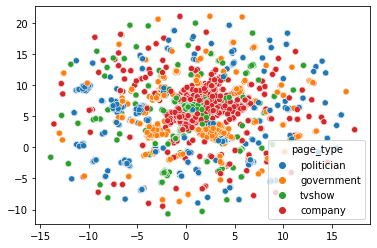

In [43]:
u = umap.UMAP(random_state=42)
nv_umap_embs = u.fit_transform(X_node_vec)

ax = sns.scatterplot(x = nv_umap_embs[:, 0], y = nv_umap_embs[:, 1], hue = y)